In [28]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import pandas as pd
import datetime as dt

#read datasets

In [29]:
data = pd.read_table('marks.txt',sep=',',header=None).values
y_array = data[:,2].reshape(-1,1)
X_array = data[:,0:2].reshape(-1,2)
X_array = np.concatenate([np.ones(X_array.shape[0]).reshape(X_array.shape[0],1),X_array],axis=1)
# initialize parameters
params_array = np.zeros(X_array.shape[1]).reshape(-1,1)

# loss func, gradients and hessians

In [30]:
def sigmoid(y_array):
    sigmoid_array = 1/(1+np.exp(-y_array))-1e-4 #to avoid entries in sigmoid array = 1
    sigmoid_array[sigmoid_array<0.0] = 1e-4
    return sigmoid_array

def cross_entropy(params_array,y_true_array,X_array):
    y_pred_array = np.matmul(X_array, params_array.reshape(-1, 1))
    y_pred_prob_array = sigmoid(y_pred_array)
    error_float = -np.sum(y_true_array*np.log(y_pred_prob_array)+(1-y_true_array)*np.log(1-y_pred_prob_array))
    return error_float

def gradient_ce(params_array,y_array,X_array,method_str='GD'):
    y_pred_array = np.matmul(X_array, params_array.reshape(-1, 1))
    y_pred_prob_array = sigmoid(y_pred_array)
    grad_array = X_array*(y_pred_prob_array-y_array)
    if method_str=='SGD':
        len_int = len(grad_array)
        SGD_size_int = int(len_int*0.5)
        random_idx_array = np.random.randint(0,len_int-1,SGD_size_int)
        grad_output_array = grad_array[random_idx_array]
        grad_output_array = np.sum(grad_output_array, axis=0)
    elif method_str=='GD':
        grad_output_array = np.mean(grad_array,axis=0)
    return grad_output_array.reshape(-1,1)
def hessian(params_array,X_array):
    y_pred_array = np.matmul(X_array, params_array.reshape(-1, 1))
    y_pred_prob_array = sigmoid(y_pred_array)
    S_w_array = np.diag(y_pred_prob_array.flatten())
    H_array = np.matmul(np.matmul(X_array.T,S_w_array),X_array)
    return H_array
#generate z for contour plot
def contour_loss(x1, x2):
    error_array = np.zeros(shape=(x1.shape[0],x2.shape[0]))
    for i in range(x1.shape[0]):
        for j in range(x2.shape[0]):
            w0 = x1[0,i]
            w1 = x2[j,0]
            param_array = np.array((-24,w0,w1)).reshape(-1,1)#fix constant's coefficient as -24
            error_array[i,j] = cross_entropy(param_array,y_array,X_array)
    return error_array

# Gradient Methods

<ipython-input-30-a14a42fcb865>:2: RuntimeWarning: overflow encountered in exp
  sigmoid_array = 1/(1+np.exp(-y_array))-1e-4 #to avoid entries in sigmoid array = 1


Error: 20.39272215857006
 Params: [[-23.52560407]
 [  0.19315348]
 [  0.18824256]]
Run time: 31.916666666666668 mins


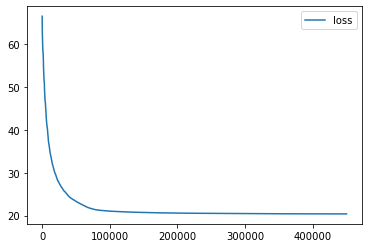

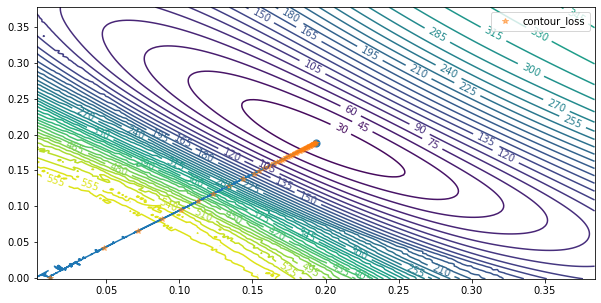

accuracy: 89.0%


In [31]:
class gradient_descent():
    def __init__(self,gradient_func,obj_func,params_array,y_array,X_array,n_iteration=10000,method_str = 'GD',lr_float = None):
        self.gradient = gradient_func
        self.obj_func = obj_func
        self.params_array = params_array
        self.y_array = y_array
        self.X_array = X_array
        self.n_iteration = n_iteration
        self.method_str = method_str
        self.lr_float = lr_float
        self.params_list = []
        self.loss_list = []
    def Backtrack_LineSearch(self,alpha_float = None,beta_float = None):
        t_float = 1
        if alpha_float is None:
            alpha_float = np.random.uniform(0,0.5,1)[0]
        if beta_float is None:
            beta_float = np.random.uniform(0,1,1)[0]
        grad_array = self.gradient(self.params_array,self.y_array,self.X_array,self.method_str)
        error_bef_float = self.obj_func(self.params_array,self.y_array,self.X_array)
        error_aft_float = self.obj_func(self.params_array-t_float*grad_array,self.y_array,self.X_array)
        while error_aft_float > error_bef_float-alpha_float*t_float*np.matmul(grad_array.T,grad_array)[0][0]:
            t_float = beta_float*t_float
            error_aft_float = self.obj_func(self.params_array - t_float * grad_array, self.y_array, self.X_array)
        if t_float<1e-6:
            t_float = 1e-2
        return t_float

    def fit(self):
        step_int = 0
        while step_int <= self.n_iteration:
            grad_array = self.gradient(self.params_array, self.y_array, self.X_array,self.method_str)
            #backtrack line search
            if self.lr_float is None:
                lr_float = self.Backtrack_LineSearch()
            else:
                lr_float = self.lr_float
            # update params
            delta_params_array = lr_float * grad_array
            self.params_array = np.add(self.params_array,-delta_params_array)
            error_float = self.obj_func(self.params_array,self.y_array,self.X_array)
            self.loss_list.append(error_float)
            #print(f'error {step_int} : {error_float} \nParams: {self.params_array}\n')
            self.params_list.append(self.params_array)
            #iteration break
            step_int+=1
        print(f'Error: {error_float}\n Params: {self.params_array}')
    def plot_params(self):
        params_history_array = np.concatenate(self.params_list,axis=1)
        params_size_int = params_history_array.shape[1]
        plt.plot(self.loss_list, label='loss')
        plt.legend()
        plt.show()
        plt.figure(figsize=(10,5))
        w0_max_float = np.max(params_history_array[1,:])
        w0_min_float = np.min(params_history_array[1,:])
        w1_max_float = np.max(params_history_array[2,:])
        w1_min_float = np.min(params_history_array[2,:])
        w0_range_array = np.linspace(w0_min_float,2*w0_max_float-w0_min_float,150)
        w1_range_array = np.linspace(w1_min_float,2*w1_max_float-w1_min_float,150)
        W0,W1 = np.meshgrid(w0_range_array,w1_range_array)
        z = contour_loss(W0,W1)
        contours = plt.contour(W0,W1,z,40)
        plt.clabel(contours,inline=True,fontsize=10)
        plt.plot(params_history_array[1,:],params_history_array[2,:])
        sample_array = np.linspace(params_size_int-1,50,dtype=np.int64)
        plt.plot(params_history_array[1,sample_array],params_history_array[2,sample_array],'*',label = 'contour_loss',alpha=0.5)
        plt.scatter(params_history_array[1,-1],params_history_array[2,-1],marker='o',s = 50)
        plt.legend()
        plt.show()
# fitting
model1 = gradient_descent(gradient_ce,cross_entropy,params_array,y_array,X_array,n_iteration = 450000,method_str = 'GD',lr_float = None)
# timing
pre_dt = dt.datetime.now()
model1.fit()
aft_dt = dt.datetime.now()
run_time = (aft_dt-pre_dt).seconds/60
print(f'Run time: {run_time} mins')
model1.plot_params()

#params_array = np.array([0.1033721,0.19987258,-24.86874868]).reshape(-1,1)
y_pred_array = np.matmul(model1.X_array,model1.params_array)
y_prob_array = sigmoid(y_pred_array)
y_class_array = (y_prob_array>=0.5).astype(int)
accuracy_float = np.sum((y_array-y_class_array)==0)/len(y_array)*100
print(f'accuracy: {accuracy_float}%')

Gradient Descent can approach to the solution in "logistic-regression.pdf" with over 400000 iteration, which is very slow.

# Newton Methods

In [32]:
class Newton_Method:
    def __init__(self,params_array,y_array,X_array,obj_func,grad_func,Hessian_func,n_interation_int = 50000,lr_float = None,method = 'GD'):
        self.params_array = params_array
        self.y_array = y_array
        self.X_array = X_array
        self.obj_func = obj_func
        self.gradient = grad_func
        self.hessian = Hessian_func
        self.n_interation = n_interation_int
        self.lr_float = lr_float
        self.method_str = method
        self.params_list = []
        self.loss_list = []
    def Backtrack_LineSearch(self,alpha_float = None,beta_float = None):
        t_float = 1
        if alpha_float is None:
            alpha_float = np.random.uniform(0,0.5,1)[0]
        if beta_float is None:
            beta_float = np.random.uniform(0,1,1)[0]
        grad_array = self.gradient(self.params_array,self.y_array,self.X_array,self.method_str)
        error_bef_float = self.obj_func(self.params_array,self.y_array,self.X_array)
        error_aft_float = self.obj_func(self.params_array-t_float*grad_array,self.y_array,self.X_array)
        while error_aft_float > error_bef_float-alpha_float*t_float*np.matmul(grad_array.T,grad_array)[0][0]:
            t_float = beta_float*t_float
            error_aft_float = self.obj_func(self.params_array - t_float * grad_array, self.y_array, self.X_array)
        if t_float<1e-3:
            t_float = 1e-3
        return t_float

    def fit(self):
        for i in range(self.n_interation):
            grad_array = self.gradient(self.params_array,self.y_array,self.X_array)
            hessian_array = hessian(self.params_array,X_array)
            delta_params_array = np.matmul(np.linalg.pinv(hessian_array),grad_array)
            if self.lr_float is None:
                lr_float = self.Backtrack_LineSearch()
            else:
                lr_float = self.lr_float
            self.params_array = self.params_array-lr_float*delta_params_array
            self.params_list.append(self.params_array)
            error_float = cross_entropy(self.params_array,y_array,X_array)
            self.loss_list.append(error_float)
        print(f'params: {self.params_array}')

    def plot_params(self):
        params_history_array = np.concatenate(self.params_list,axis=1)
        params_size_int = params_history_array.shape[1]
        plt.plot(self.loss_list, label='loss')
        plt.legend()
        plt.show()
        plt.figure(figsize=(10,5))
        w0_max_float = np.max(params_history_array[1,:])
        w0_min_float = np.min(params_history_array[1,:])
        w1_max_float = np.max(params_history_array[2,:])
        w1_min_float = np.min(params_history_array[2,:])
        w0_range_array = np.linspace(w0_min_float,2*w0_max_float-w0_min_float,150)
        w1_range_array = np.linspace(w1_min_float,2*w1_max_float-w1_min_float,150)
        W0,W1 = np.meshgrid(w0_range_array,w1_range_array)
        z = contour_loss(W0,W1)
        contours = plt.contour(W0,W1,z,20)
        plt.clabel(contours,inline=True,fontsize=10)
        plt.plot(params_history_array[1,:],params_history_array[2,:])
        sample_array = np.linspace(params_size_int-1,50,dtype=np.int64)
        plt.plot(params_history_array[1,sample_array],params_history_array[2,sample_array],'*',label = 'contour_loss',alpha=0.5)
        plt.scatter(params_history_array[1,-1],params_history_array[2,-1],marker='o',s = 50)
        plt.legend()
        plt.show()

(1) Not apply backtracking line search for learning rate

params: [[-24.82237166]
 [  0.20348616]
 [  0.19866432]]
Run time: 0.08333333333333333 mins


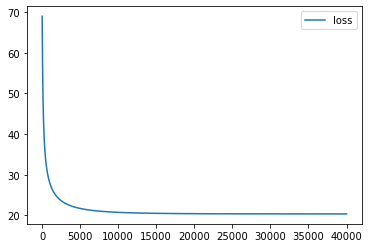

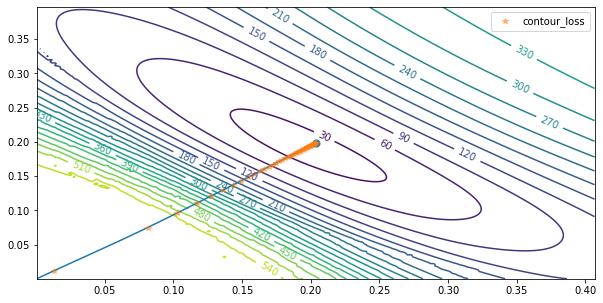

accuracy: 89.0%


In [33]:
model2 = Newton_Method(params_array,y_array,X_array,cross_entropy,gradient_ce,hessian,n_interation_int=40000,lr_float = 1,method='GD')
# timing
pre_dt = dt.datetime.now()
model2.fit()
aft_dt = dt.datetime.now()
run_time = (aft_dt-pre_dt).seconds/60
print(f'Run time: {run_time} mins')
plt.close()
model2.plot_params()
y_pred_array = np.matmul(X_array,model2.params_array)
y_prob_array = sigmoid(y_pred_array)
y_class_array = (y_prob_array>=0.5).astype(int)
accuracy_float = np.sum((y_array-y_class_array)==0)/len(y_array)*100
print(f'accuracy: {accuracy_float}%')

Above results shows that Newton Method is much faster than Gradient Descent in this scenario, which takes about 40000 iteration,
while gradient descent takes about 400000 iterations, nearly 10 times of Newton method. Also single iteration of Newton method is faster than Gradient Descent. Therefore, as to time, Newton method is nearly 400 times faster.

(2) Backtracking line search for learning rate

params: [[-1.29349415]
 [ 0.01059275]
 [ 0.0098617 ]]
Run time: 1.35 mins


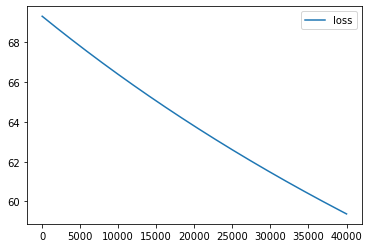

<ipython-input-32-82791b9da8f8>:60: UserWarning: No contour levels were found within the data range.
  contours = plt.contour(W0,W1,z,20)


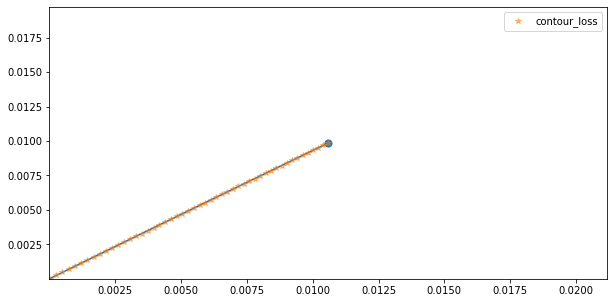

accuracy: 89.0%


In [35]:
model3 = Newton_Method(params_array,y_array,X_array,cross_entropy,gradient_ce,hessian,
                       n_interation_int=40000,lr_float = None,method='GD')
# timing
pre_dt = dt.datetime.now()
model3.fit()
aft_dt = dt.datetime.now()
run_time = (aft_dt-pre_dt).seconds/60
print(f'Run time: {run_time} mins')
plt.close()
model3.plot_params()
y_pred_array = np.matmul(X_array,model3.params_array)
y_prob_array = sigmoid(y_pred_array)
y_class_array = (y_prob_array>=0.5).astype(int)
accuracy_float = np.sum((y_array-y_class_array)==0)/len(y_array)*100
print(f'accuracy: {accuracy_float}%')

The above results show that within same iteration times backtracking line search actually does harm to Newton method which greatly slows down the algorithm.
The contour graph doesn't show up because loss is too large and basically the same for every point to plot the contour.